### This jupyter notebook is to test the yahoo finance

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## import model objects
from sklearn.model_selection import train_test_split
import yfinance as yf
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer

In [3]:
df= pd.read_csv("dataset_reg.csv")

In [12]:
# Add date as a column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [8]:
df.dtypes

Date                     datetime64[ns, UTC]
ALV_Open                             float64
ALV_Close                            float64
ALV_High                             float64
ALV_Low                              float64
                                ...         
DNZOY_MACD_EMA                       float64
DNZOY_ROC                            float64
DNZOY_PVT                            float64
DNZOY_Bollinger_Upper                float64
DNZOY_Bollinger_Lower                float64
Length: 174, dtype: object

In [11]:
df.describe()

,ALV_Open,ALV_Close,ALV_High,ALV_Low,ALV_Volume,ALV_Change,ALV_Gain,ALV_Loss,ALV_Avg_Gain,ALV_Avg_Loss,...,DNZOY_change_in_price,DNZOY_RSI,DNZOY_k_percent,DNZOY_r_percent,DNZOY_MACD,DNZOY_MACD_EMA,DNZOY_ROC,DNZOY_PVT,DNZOY_Bollinger_Upper,DNZOY_Bollinger_Lower
count,1237.000000,1237.000000,1237.000000,1237.000000,1.237000e+03,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,...,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000
mean,89.121027,89.138820,90.147712,88.140121,6.783613e+05,0.012627,0.717930,0.705303,0.715171,0.705350,...,0.001823,51.224735,53.539972,-46.460028,0.016926,0.017620,0.394768,-267417.768975,15.483610,13.665366
std,15.453859,15.465091,15.439312,15.495578,5.209733e+05,1.907268,1.129755,1.160943,0.270928,0.370113,...,0.279927,16.237170,30.339025,30.339025,0.300690,0.283468,6.380105,96244.240682,3.091457,2.758083
min,38.169998,40.180000,42.000000,38.160000,6.970000e+04,-10.919998,0.000000,0.000000,0.133572,0.084286,...,-1.459999,10.537741,0.000000,-100.000000,-1.164845,-1.001588,-29.066806,-354688.617206,8.808903,6.477781
25%,78.489998,78.480003,79.389999,77.559998,4.216000e+05,-1.119999,0.000000,0.000000,0.515714,0.456429,...,-0.140001,38.919119,25.890689,-74.109311,-0.188280,-0.182522,-3.894166,-320128.156080,13.580105,11.792023
50%,90.389999,90.570000,91.500000,89.599998,5.850000e+05,0.090004,0.090004,0.000000,0.700000,0.642857,...,0.004999,51.977487,56.969685,-43.030315,0.046489,0.035631,0.461816,-289908.919049,15.982264,13.866933
75%,98.900002,98.830002,100.010002,97.809998,8.019000e+05,1.110001,1.110001,1.119999,0.886428,0.877857,...,0.170000,62.863776,80.303153,-19.696847,0.223486,0.218721,4.837238,-265353.393644,17.638117,15.841674
max,128.210007,129.110001,129.380005,127.540001,1.245950e+07,9.510002,9.510002,10.919998,1.952857,2.628572,...,1.425000,89.660469,100.000000,-0.000000,0.689545,0.643176,19.492603,90489.739035,23.148085,19.736911


In [14]:
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(months=2)
df_last_2_months = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Step 2: Prepare features (X) and target (y)
X = df_last_2_months.drop(columns=['Date', 'DNZOY_Close_pred', 'DNZOY_Bollinger_Upper', 'DNZOY_Bollinger_Lower'])
y = df_last_2_months['DNZOY_Close_pred']

In [18]:
# Standardize and remove skewness
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
power_transformer = PowerTransformer()
X_transformed = power_transformer.fit_transform(X_scaled)

In [19]:
# Step 3: Split data - keep the last 1 week as an unseen test set
split_index = len(X_transformed) - 7
X_train_val, X_unseen_test = X_transformed[:split_index], X_transformed[split_index:]
y_train_val, y_unseen_test = y[:split_index], y[split_index:]

In [20]:
print(np.isnan(X_train_val).sum())  # Check for NaN in training data
print(np.isnan(X_unseen_test).sum())   # Check for NaN in test data

0
0


In [21]:
# Deftine the parameter grid for grid sed
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [1, 10, 50, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}
svr = SVR()


grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_val, y_train_val)
best_params = grid_search.best_params_
# Train the model with the best parameters
best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_val, y_train_val)
## Make predictions: on the test set (i.e. last week)
predictions = best_svr_model.predict(X_unseen_test)
mse = mean_squared_error(y_unseen_test,predictions)

In [22]:
print("Best Hyperparameters",best_params)
print("Mean Squared Error",mse)

Best Hyperparameters {'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}
Mean Squared Error 0.08881290657807951


In [23]:
# Chosen model
modelSVR = SVR(kernel='linear', C=1, gamma=0.01)

In [25]:
# checking 
modelSVR.fit(X_train_val, y_train_val)
## Make predictions: on the test set (i.e. last week)
predictions = best_svr_model.predict(X_unseen_test)
mse = mean_squared_error(y_unseen_test,predictions)
print("Mean Squared Error",mse)

Mean Squared Error 0.08881290657807951


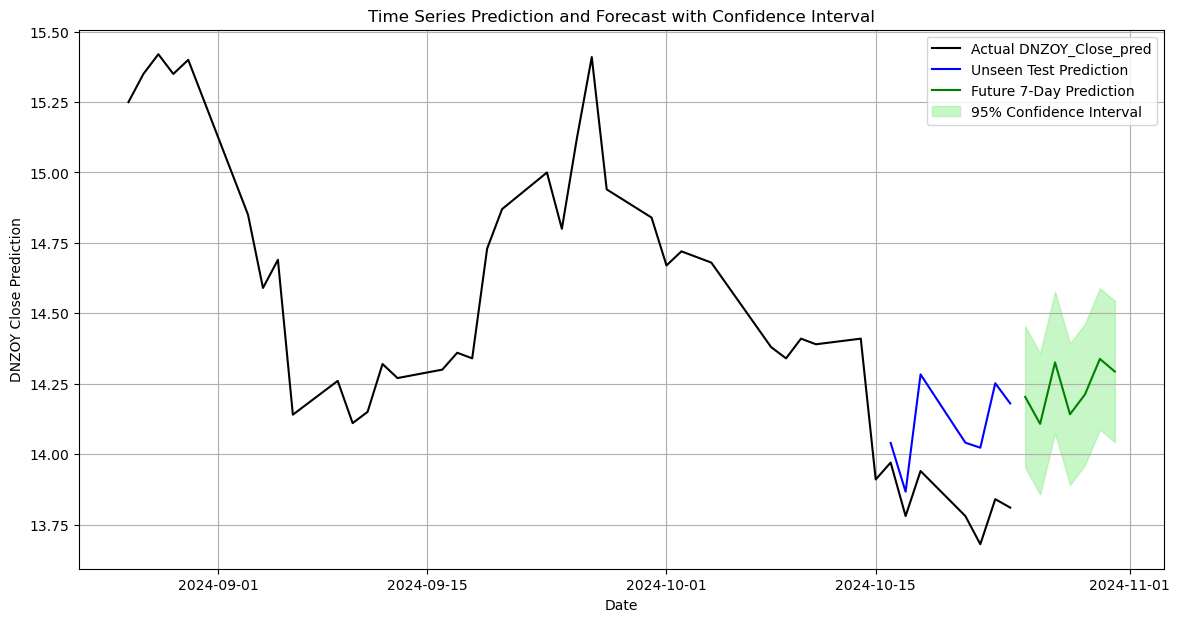

In [30]:
# Step 7: Forecast the next 7 days with a confidence interval
future_7_days = X_transformed[-7:]  # Use the last week for forecasting
future_predictions = modelSVR.predict(future_7_days)
# Calculate confidence interval (simple approximation based on prediction standard deviation)
std_dev = np.std(predictions - y_unseen_test)
upper_bound = future_predictions + (1.96 * std_dev)
lower_bound = future_predictions - (1.96 * std_dev)

# # Plot the results
plt.figure(figsize=(14, 7))
# Actual data
plt.plot(df_last_2_months['Date'], y, label="Actual DNZOY_Close_pred", color='black')
# Predictions on unseen test
plt.plot(df_last_2_months['Date'].iloc[-7:], predictions, label="Unseen Test Prediction", color='blue')
# Future forecast
future_dates = pd.date_range(df_last_2_months['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, future_predictions, label="Future 7-Day Prediction", color='green')
plt.fill_between(future_dates, lower_bound, upper_bound, color='lightgreen', alpha=0.5, label="95% Confidence Interval")

plt.xlabel("Date")
plt.ylabel("DNZOY Close Prediction")
plt.title("Time Series Prediction and Forecast with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

## Some commodity tickers

- gold: SB=F
- Crude Oil: CL=F
- Silver: XAG=